In [4]:
#importing  rethequired libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sqlite3
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import gensim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split# for shuffle = false
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
#read the dataset
conn=sqlite3.connect('final.sqlite')
final=pd.read_sql_query("""select * from Reviews""",conn)
conn.close()
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_text_nonstem,cleaned_summ_nonstem
0,158339,171676,B000PVVG3O,A2Z6GD6SGCJQYZ,J. Hruby,0,0,1,1331164800,Great stuff for hiking/backpacking! Here's a r...,"For backpacking, using the ""Pack it in, pack i...",backpack use pack pack leav trace frame mind a...,backpacking using pack pack leave trace frames...,great stuff hiking backpacking heres recipe
1,154483,167502,B001RDOVKE,A1ISRCMLBVFPA0,Bill Nesbit,4,4,1,1288310400,What a Treat!!,I was pleasantly surprised at how wonderful th...,pleasant surpris wonder quit honest best turtl...,pleasantly surprised wonderful quite honestly ...,treat
2,94670,102898,B000HZIB9A,A59HMW5T6TP,Angela A. Hooper,1,1,1,1206576000,Awesome Marinade!!!!!,This is the best marinade ever to put on chick...,best marinad ever put chicken unfortun absolut...,best marinade ever put chicken unfortunately a...,awesome marinade
3,343872,371996,B003LVWCTW,A13M50YKJGDVBG,"S. Glosson ""eyesgreen52""",0,0,1,1322179200,Warm Comfort food,Excellent and you can use chicken broth and ro...,excel use chicken broth rossiteri chicken inst...,excellent use chicken broth rossiterie chicken...,warm comfort food
4,163030,176755,B000YFDON6,A2GAI61W3WHRJY,C. G. Royal,2,3,1,1217376000,gum,Product arrived very quickly. Nice job. this...,product arriv quick nice job best cinnamon gum...,product arrived quickly nice job best cinnamon...,gum


In [3]:
#list of sent pickle file
with open('list_of_sent_for_input_to_w2v.pkl', 'rb') as pickle_file:
    list_of_sent = pickle.load(pickle_file)

In [5]:
#google W2V text file
with open('google_word2vec_model.txt', 'rb') as pickle_file:
    google_w2v = pickle.load(pickle_file)

In [6]:
#code to calc tfidf vectorizer 
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(final['cleaned_text_nonstem'].values)
tfidf_feat = tfidf_vect.get_feature_names()

* fn to calc tfidf weighted avg w2v

In [7]:
def calc_tfidf_w2v(list_of_sent, w2v_model, tf_idf, tfidf_feat,start_row):
    '''This function takes in 5 parameters as follows:
       1. list_of_sent - This is the list of sentences/reviews for which sentence vetors are to be constructed
       2. w2v_model - This is the Word2Vec model which is trained on the working corpus - contains the word vectors
       3. tf_idf - This is the TF-IDF model built using the same reviews/sentences - it is the TF-IDF sparse matrix
       4. tfidf_feat - This is the feature vector constructed from the TF-IDF model
       
       Return Value:
       tfidf_sent_vectors - This is a list of sentence/review vectors constructed by using tfidf weighted average on the word vectors
    '''
    
    ## Initialize an empty list
    sent_vectors = []
    row = 0
    ## Consider one sentence/review at a time
    for sent in list_of_sent:
        ## Initialize sentence vector to 0
        sen_vec = np.zeros(300)
        ## Initialize weighted sum to 0
        weighted_sum = 0
        ## Consider the words one by one
        for word in sent:
            try:
                ## Calculate the word vector using the W2V model
                vec = w2v_model[word]
                ## Calculate tfidf value of the word in that review using tfidf model
                tf_idf = tfidf[start_row, tfidf_feat.index(word)]
                ## Add the product of tfidf*word_vec to the sentence vector (This is the numerator)
                sen_vec += vec*tf_idf 
                ## Sum all the tfidf values (This is the denominator)
                weighted_sum += tf_idf  
            except:
                pass
        
        ## Divide the numerator by the denominator to get the sentence vector
        sen_vec /= weighted_sum
        print(start_row, weighted_sum)
        ## Add the sentence vector in the final list
        sent_vectors.append(sen_vec)
        start_row += 1
    ## return the list of all the sentence vectors
    return sent_vectors

In [ ]:
tfidf_sent_vector = calc_tfidf_w2v(list_of_sent[:60000], google_w2v, tfidf, tfidf_feat, 0)

In [9]:
#save the sent vectors to hard disk
with open('weighted_avg_w2v.pkl','wb') as pickle_file:
    pickle.dump(tfidf_sent_vector,pickle_file)

In [10]:
#opening pickle file of tfidf sent vectors
with open('weighted_avg_w2v.pkl','rb') as pickle_file:
    tfidf_sent_vector = pickle.load(pickle_file)

In [11]:
x=np.array(tfidf_sent_vector)
df=pd.DataFrame(x) #creating a dataframe of tfidf sent vectors
df.shape

(60000, 300)

In [12]:
df['time']=final['Time'].iloc[:60000] #sampling the dataset
df['score']=final['Score'].iloc[:60000]

In [13]:
df=df.dropna(axis =0 ) #removing all those rows which contains null values

In [14]:
df=df.sort_values(['time']) #sorting on time
print(df.shape)
df.head()

(59998, 302)


,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,time,score
8085,0.062006,-0.001658,-0.111280,0.109549,-0.079417,0.037457,0.110930,-0.043663,0.023995,0.049165,...,-0.116743,0.029091,0.006191,-0.008417,0.032929,0.021366,0.007655,-0.019193,944092800,1
32847,0.003465,0.028732,-0.018698,0.136915,-0.059155,-0.021862,0.017819,-0.069852,0.040595,0.084407,...,-0.094117,-0.001312,-0.050574,-0.078621,-0.033452,-0.078896,-0.031227,0.021306,1012780800,1
7848,0.037415,-0.035357,0.001373,0.085302,-0.053043,0.024755,0.021655,-0.037954,0.073549,0.038541,...,-0.075883,-0.014201,-0.061517,-0.065902,0.022953,-0.043048,-0.002478,-0.002785,1014163200,1
14778,0.019556,0.030235,-0.022613,0.066466,-0.001294,-0.010194,0.022104,-0.082219,0.040394,0.063478,...,-0.046666,0.010685,-0.041257,-0.040610,-0.002259,-0.055486,-0.017451,0.004767,1015545600,1
30941,0.048515,-0.001051,-0.019470,0.119940,0.063291,0.036864,0.059346,0.121984,0.007228,-0.048536,...,-0.178375,-0.157791,-0.062356,-0.062002,0.094937,-0.025771,0.007637,0.034338,1018396800,1


In [15]:
x=df.iloc[:,:300].values #considering only first 300 features
print(type(x))
y=df['score'].values
type(y)

<class 'numpy.ndarray'>


numpy.ndarray

In [16]:
s=StandardScaler()
x=s.fit_transform(x)
x[:5,:]

array([[ 1.24116039, -0.74261425, -2.02702776, ...,  0.45819294,
        -0.46469621, -0.43173613],
       [ 0.07454026, -0.14684314, -0.20477713, ..., -1.23180916,
        -1.21373331,  0.32730799],
       [ 0.75110322, -1.4032601 ,  0.19027058, ..., -0.62756659,
        -0.65990932, -0.12421839],
       [ 0.39519544, -0.11736952, -0.2818369 , ..., -0.83721705,
        -0.94835044,  0.01733164],
       [ 0.97229988, -0.730721  , -0.21996613, ..., -0.33634817,
        -0.46503719,  0.57154978]])

In [17]:
#train-test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.35,shuffle =False) 

*  Code to perform k fold

the optimal value of k is 15


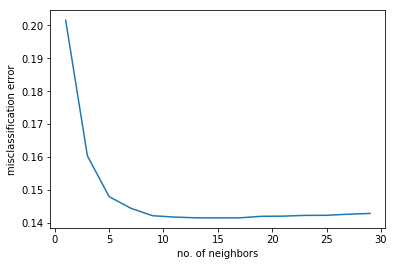

In [18]:
neighbors=list(range(1,31,2))
cv_scores=[]

for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k)
    score=cross_val_score(knn,x_train,y_train,cv=5,scoring='accuracy') #Hyper parameter -CV
    cv_scores.append(score.mean())
    
MSE=[1-x for x in cv_scores]

optimal_k=neighbors[MSE.index(min(MSE))]
print('the optimal value of k is %d' % optimal_k)
plt.plot(neighbors,MSE)
plt.xlabel('no. of neighbors')
plt.ylabel('misclassification error')
plt.show()

In [19]:
#fitting the model on optimal value of k
classifier = KNeighborsClassifier(n_neighbors = optimal_k)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [20]:
#generating prediction
y_pred = classifier.predict(x_test) 

In [21]:
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
acc

82.80952380952381

In [25]:
results = confusion_matrix(y_test, y_pred).T
print(results)

[[  181    62]
 [ 3548 17209]]
